In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [4]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.nm,
             'ring_width': 5,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m,
             'label': 'OAP3'} #1/u.mm}

main_dir = '/home/jhen/XWCL/code/CDEEP/WFE/OAP/'
surf_dir = main_dir + 'surface/{0}/'.format(opt_parms['label'])
psd_dir = main_dir + 'psd/{0}/'.format(opt_parms['label'])
sn_label = [1,2]

oap=[]
for n in range(0,len(sn_label)):
    # Write filename
    n_oap = '{0}_SN{1}'.format(opt_parms['label'], sn_label[n])
    surf_data_loc = surf_dir + '{0}_{1}CA_pp'.format(n_oap, opt_parms['ca'])
    
    # create the object
    t_oap = psd.surfPSD(surf_name = n_oap)
    
    # open the files
    t_oap.open_surf(fileloc=surf_data_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
    t_oap.open_mask(fileloc=surf_data_loc+'_mask.fits')

    # calculate the PSD
    t_oap.calc_psd(oversamp = opt_parms['ovs'], kmid_ll=opt_parms['kmid_ll'], 
                   khigh_ll=opt_parms['khigh_ll'])
    
    # save the PSD file for future opening
    t_oap.write_psd_file(filename=psd_dir +'psd_2D_{0}.fits'.format(n_oap), 
                         psd_data=t_oap.psd_cal,
                         single_precision=False)
    
    # calculate the radial profile
    print('Starting radial profile for {0}'.format(n_oap))
    t_oap.calc_psd_radial(ring_width=5, kmin=t_oap.k_min)
    print('PSD and radial profile for {0} complete\n'.format(n_oap))
    
    oap.append(t_oap)
    
print('All {0} PSD complete'.format(opt_parms['label']))

Starting radial profile for OAP3_SN1
PSD and radial profile for OAP3_SN1 complete

Starting radial profile for OAP3_SN2
PSD and radial profile for OAP3_SN2 complete

All OAP3 PSD complete
CPU times: user 5min 54s, sys: 2min 7s, total: 8min 2s
Wall time: 7min 59s


### Build the average PSD

In [5]:
np.isclose(oap[0].k_min.value, oap[1].k_min.value)

True

In [6]:
(oap[0].k_min.value, oap[1].k_min.value)

(78.71104047120697, 78.71104047120697)

In [7]:
np.isclose(oap[0].k_max.value, oap[1].k_max.value)

True

In [8]:
np.isclose(oap[0].delta_k.value, oap[1].delta_k.value)

True

In [9]:
# check that all the analyzed spatial frequencies are the same
np.product(np.isclose(oap[0].k_radial.value, oap[1].k_radial.value))

1

The spatial frequencies match, so the average of the normalized PSDs can be taken radially.

In [10]:
# calculate the average PSD from the normalized values
# since the optics have the same sampling and size, their spatial frequency ranges will be the same.
# we can go directly to the psd value average
psd_norm_set = np.zeros((2, len(oap[0].psd_radial_cal)))
psd_norm_set[0] = oap[0].psd_radial_cal.value/oap[0].var.value
psd_norm_set[1] = oap[1].psd_radial_cal.value/oap[1].var.value

# now take the average psd norm
psd_norm_avg = np.mean(psd_norm_set, axis=0)
# multiply average psd norm by the average variance
avg_var = np.mean([oap[0].var.value, oap[1].var.value])
psd_cal_avg = psd_norm_avg*avg_var*oap[0].psd_radial_cal.unit

In [13]:
(oap[0].var.value, oap[1].var.value, avg_var)

(40.73226138164132, 56.716781942338564, 48.72452166198994)

In [15]:
(np.sqrt(oap[0].var.value), np.sqrt(oap[1].var.value), np.sqrt(avg_var))

(6.382183120346934, 7.531054504007959, 6.980295241749444)

In [19]:
psd_2d_norm_avg = oap[0].psd_norm + oap[1].psd_norm
psd_2d_norm_avg /= 2 # normalize the average
psd_2d_cal_avg = psd_2d_norm_avg*avg_var
psd_avg_rms = psd.do_psd_rms(psd_data=psd_2d_cal_avg, delta_k=oap[0].delta_k, 
                             k_tgt_lim=(oap[0].k_min, oap[0].k_max), print_rms=True)

Target range - k_min: 78.711 1 / m and k_high: 15742.208 1 / m
RMS value: 6.2111


Discrepancies with the RMS: The RMS taken from the surface measurement and the PSDs don't always match up, with the PSD rms tending to be lower. But it's usually only within 1 nanometer, which is enough to suggest numerical differences. In this case, the average variance applied to the average normalized PSD is higher than the two OAP's PSD rms value. The math isn't wrong, I'm just not comparing things completely fairly because I don't want to recalculate things.

Text(0.5, 1.0, 'OAP3 PSD')

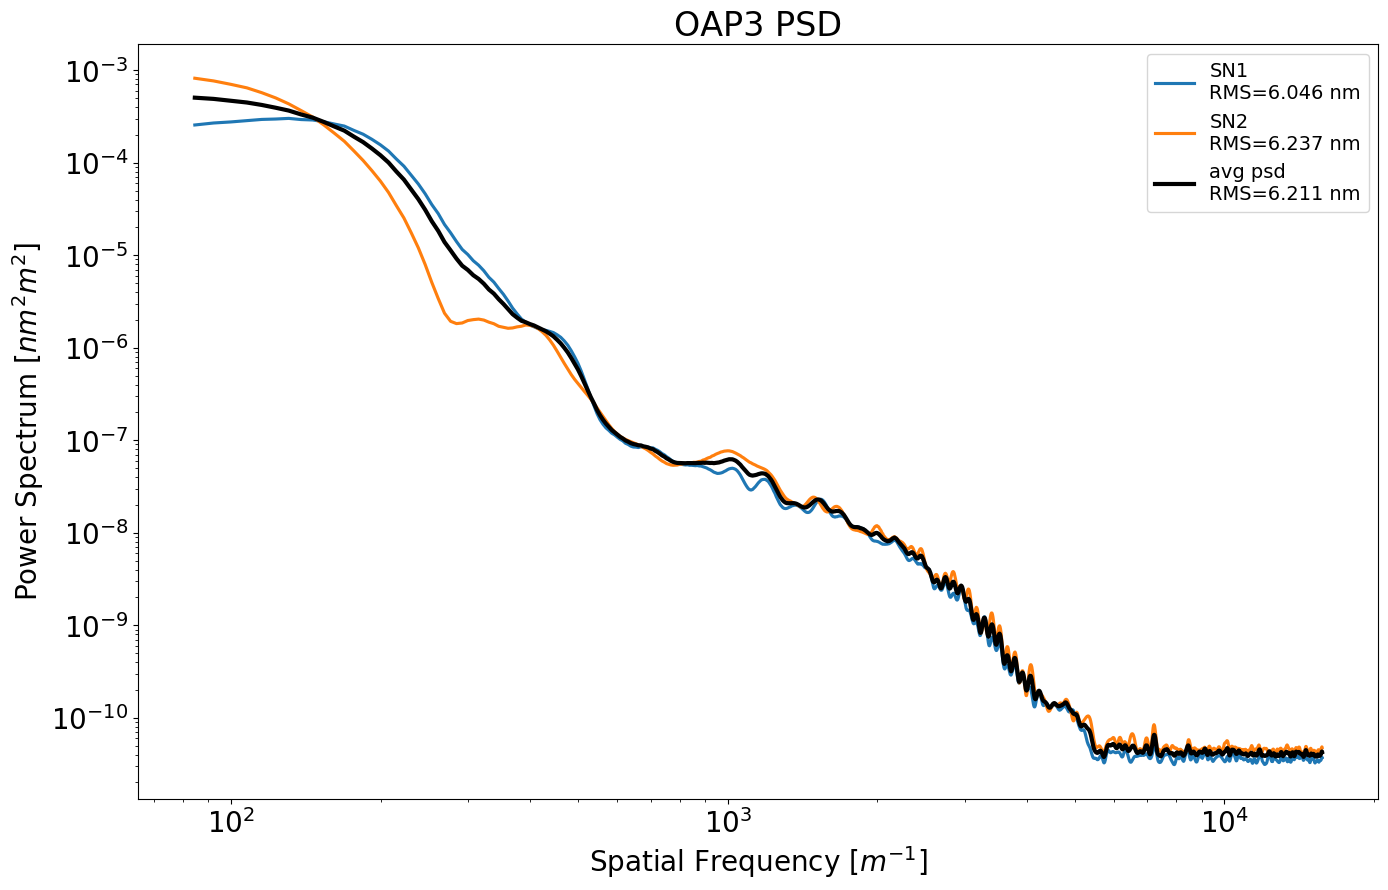

In [20]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[16,10], dpi=100, facecolor='white')
for nf in range(0, len(sn_label)):
    plt.loglog(oap[nf].k_radial.value, oap[nf].psd_radial_cal.value, linewidth=2.25,
               label='SN{0}\nRMS={1:.3f}'.format(sn_label[nf], oap[nf].rms_tot))
plt.loglog(oap[nf].k_radial.value, psd_cal_avg.value, linewidth=3, color='k',
           label='avg psd\nRMS={1:.3f}'.format(sn_label[nf], psd_avg_rms*u.nm))
#plt.axhline(y=bsr_1.value, ls='--', color='blue', label='SN1 bsr={0:.3e}'.format(bsr_1))
#plt.axhline(y=bsr_2.value, ls='--', color='orange', label='SN2 bsr={0:.3e}'.format(bsr_2))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
plt.legend(prop={'size':14})#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('{0} PSD'.format(opt_parms['label']))

### Save the radial PSD profiles
It's annoying to recalculate this again and again

In [21]:
# write the radial PSD values into file because it's slow to calculate
for n in range(0, len(sn_label)):
    # set up the data
    # row 0 is the spatial frequency value
    # row 1 is the psd value
    psd_mat = np.zeros((2, len(oap[n].k_radial)))
    psd_mat[0] = oap[n].k_radial.value
    psd_mat[1] = oap[n].psd_radial_cal.value

    # set up the header
    optdata = oap[n]
    hdr = fits.Header()
    hdr.set('opt_name', optdata.surf_name,
            'optic name')
    hdr.set('psd_unit', str(optdata.psd_radial_cal.unit),
            'PSD units')
    hdr.set('rms', optdata.rms_tot.value,
            'CA range rms [{0}]'.format(str(optdata.rms_tot.unit)))
    hdr.set('var', optdata.var.value,
            'variance for scaling norm PSD [{0}]'.format(str(optdata.var.unit)))
    hdr.set('ca', opt_parms['ca'],
            'Clear aperture percentage for optic')
    hdr.set('diam_ca', optdata.diam_ca.value, 
            'clear aperture diam [{0}]'.format(str(optdata.diam_ca.unit)))
    hdr.set('diam_pix', optdata.npix_diam,
            'number of pixels in clear aperture')
    hdr.set('oversamp', optdata.oversamp,
            'FFT size array after oversampling')
    hdr.set('delta_x', optdata.latres.value,
            'surf measurement spatial resolution [{0}]'.format(str(optdata.latres.unit)))
    hdr.set('delta_k', optdata.delta_k.value,
            'full psd spatial frequency resolution [{0}]'.format(str(optdata.delta_k.unit)))
    hdr.set('kmin', optdata.k_min.value,
            'minimum spatial frequency limit [{0}]'.format(str(optdata.k_min.unit)))
    hdr.set('kmax', optdata.k_max.value,
            'maximum spatial frequency limit [{0}]'.format(str(optdata.k_max.unit)))
    hdr.set('ringsize', opt_parms['ring_width'],
            'annular size for radial PSD averaging')
    hdr['comment'] = 'Row 1 is spatial frequency value for radial profile'
    hdr['comment'] = 'Row 2 is the PSD value at the radial spatial frequency.'

    # write to file
    fits_loc = psd_dir + 'psd_radial_{0}.fits'.format(oap[n].surf_name)
    fits.writeto(fits_loc, psd_mat, hdr, overwrite=True)

In [27]:
# save the average PSD
# set up the data
# row 0 is the spatial frequency value
# row 1 is the psd value
n=0
psd_mat = np.zeros((2, len(oap[n].k_radial)))
psd_mat[0] = oap[n].k_radial.value
psd_mat[1] = psd_cal_avg.value

# set up the header
optdata = oap[n]
hdr = fits.Header()
hdr.set('opt_name', optdata.surf_name,
        'optic name')
hdr.set('psd_unit', str(optdata.psd_radial_cal.unit),
        'PSD units')
hdr.set('rms', psd_avg_rms.value,
        'CA range rms [{0}]'.format(str(optdata.rms_tot.unit)))
hdr.set('var', avg_var,
        'variance for scaling norm PSD [{0}]'.format(str(optdata.var.unit)))
hdr.set('ca', opt_parms['ca'],
        'Clear aperture percentage for optic')
hdr.set('diam_ca', optdata.diam_ca.value, 
        'clear aperture diam [{0}]'.format(str(optdata.diam_ca.unit)))
hdr.set('diam_pix', optdata.npix_diam,
        'number of pixels in clear aperture')
hdr.set('oversamp', optdata.oversamp,
        'FFT size array after oversampling')
hdr.set('delta_x', optdata.latres.value,
        'surf measurement spatial resolution [{0}]'.format(str(optdata.latres.unit)))
hdr.set('delta_k', optdata.delta_k.value,
        'full psd spatial frequency resolution [{0}]'.format(str(optdata.delta_k.unit)))
hdr.set('kmin', optdata.k_min.value,
        'minimum spatial frequency limit [{0}]'.format(str(optdata.k_min.unit)))
hdr.set('kmax', optdata.k_max.value,
        'maximum spatial frequency limit [{0}]'.format(str(optdata.k_max.unit)))
hdr.set('ringsize', opt_parms['ring_width'],
        'annular size for radial PSD averaging')
hdr['comment'] = 'Row 1 is spatial frequency value for radial profile'
hdr['comment'] = 'Row 2 is the PSD value at the radial spatial frequency.'
hdr['comment'] = 'Avg PSD generated from averaging the normalized PSDs'
hdr['comment'] = 'and scaling by average variance value'

# write to file
fits_loc = psd_dir + 'psd_radial_{0}_avg.fits'.format(opt_parms['label'])
fits.writeto(fits_loc, psd_mat, hdr, overwrite=True)

### Inspecting the surface roughness value

In [28]:
rms_sr = [0.46*u.nm, 0.50*u.nm]
bsr_1 = rms_sr[0]**2/(np.pi*(oap[0].k_max**2-oap[0].k_min**2))
bsr_2 = rms_sr[1]**2/(np.pi*(oap[1].k_max**2-oap[1].k_min**2))

Text(0.5, 1.0, 'OAP3 PSD')

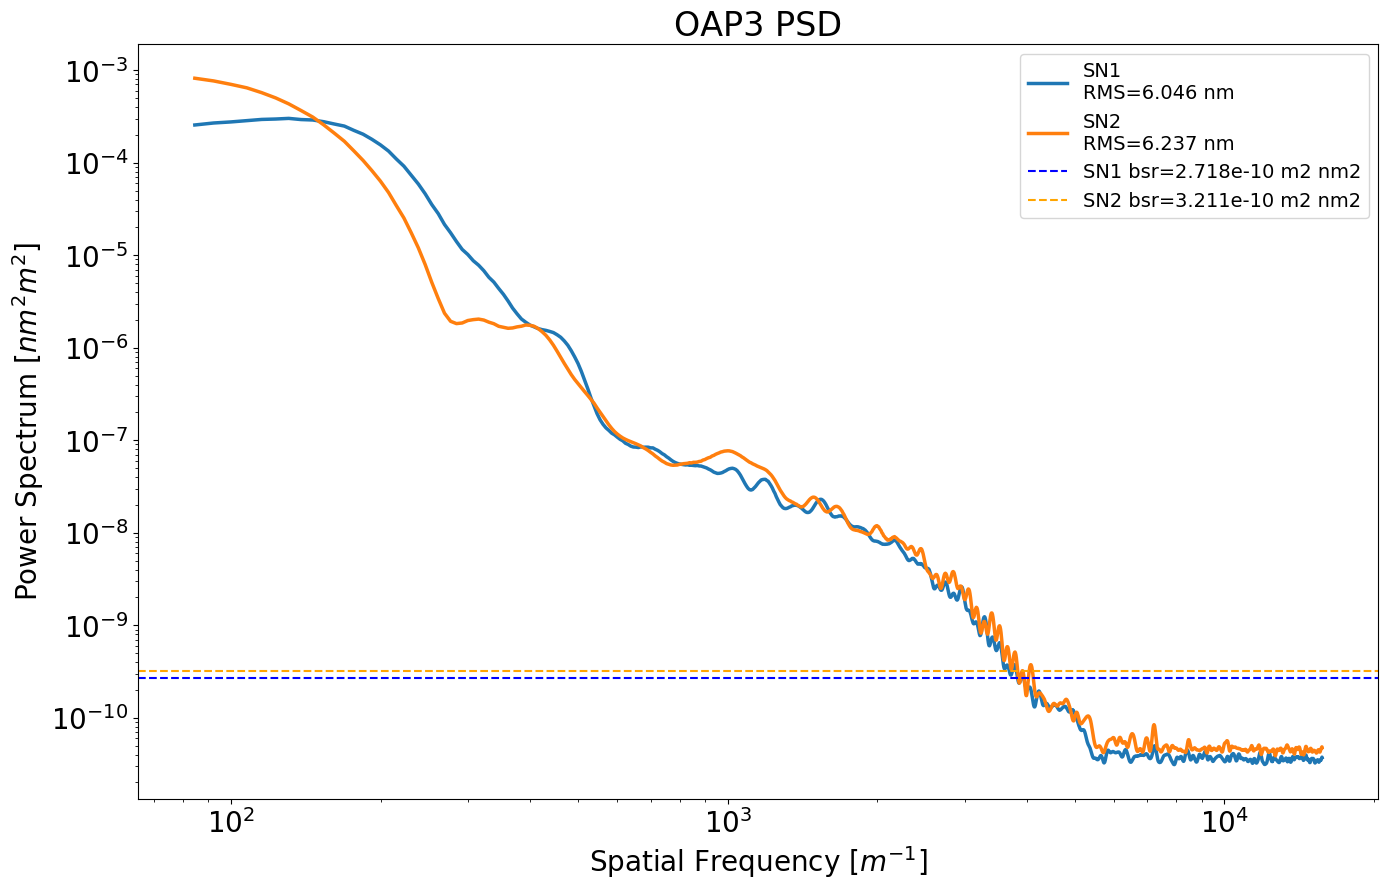

In [29]:
matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[16,10], dpi=100)
for nf in range(0, len(sn_label)):
    plt.loglog(oap[nf].k_radial.value, oap[nf].psd_radial_cal.value, linewidth=2.5,
               label='SN{0}\nRMS={1:.3f}'.format(sn_label[nf], oap[nf].rms_tot))
plt.axhline(y=bsr_1.value, ls='--', color='blue', label='SN1 bsr={0:.3e}'.format(bsr_1))
plt.axhline(y=bsr_2.value, ls='--', color='orange', label='SN2 bsr={0:.3e}'.format(bsr_2))
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
plt.legend(prop={'size':14})#,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('{0} PSD'.format(opt_parms['label']))